## Bike-rental volume prediction

The purpose of this notebook is to provide an illustration of how the FRESH algorithm can be implemented to aid in forecasting the value of a target variable without the implementation of data rolling and for data which contains inconsistent evenly spaced data points.

## Loading library scripts and data

In the following cell the functions related to the FRESH library are loaded in the 1st line while preprocessing functions used within the notebook are loaded from the folder mlutils

In [1]:
\l ../../ml.q
.ml.loadfile`:init.q
\l graphics.q
\c 15 100

/turn off any python warnings
warn:.p.import[`warnings];
warn[`:filterwarnings]["ignore"];

Load in data pertaining to a bike sharing scheme in Washington DC between 2011-2012 (This data was obtained from kaggle at: https://www.kaggle.com/marklvl/bike-sharing-dataset).

Our goal is to use the hourly data from the current day to predict if the last hour of the next day will be busier or quieter than the last hour of today.

This use case while slightly contrived and chosen to show the operation of this algorithm, it could potentially be useful in allowing an employer to anticipate if extra staff are required for the next business day, which could save on costs.

In [2]:
tabinit:("IDIIIIIIIIFFFFIII";enlist ",") 0:`:SampleDatasets/bike_rental.csv

/drop columns which contain zero variance as these would not be useful for use in a machine learning algorithm.
show tabinit:flip (where 0=var each flip tabinit) _ flip tabinit

instant dteday     season yr mnth hr holiday weekday workingday weathersit temp atemp  hum  winds..
-------------------------------------------------------------------------------------------------..
1       2011.01.01 1      0  1    0  0       6       0          1          0.24 0.2879 0.81 0    ..
2       2011.01.01 1      0  1    1  0       6       0          1          0.22 0.2727 0.8  0    ..
3       2011.01.01 1      0  1    2  0       6       0          1          0.22 0.2727 0.8  0    ..
4       2011.01.01 1      0  1    3  0       6       0          1          0.24 0.2879 0.75 0    ..
5       2011.01.01 1      0  1    4  0       6       0          1          0.24 0.2879 0.75 0    ..
6       2011.01.01 1      0  1    5  0       6       0          2          0.24 0.2576 0.75 0.089..
7       2011.01.01 1      0  1    6  0       6       0          1          0.22 0.2727 0.8  0    ..
8       2011.01.01 1      0  1    7  0       6       0          1          0.2  0.2576 0.86 0    ..


---

## Set the target values for forecasting

Next we set the target which will be estimated from the dataset. In this case we are attempting to predict if the number of bike rentals in the last hour of business will be higher or lower tomorrow than it was today.

In [3]:
lasthour:value exec last cnt by dteday from tabinit
targets:lasthour>prev lasthour

## Naive solution

Under the naive solution i.e choosing that the number of rentals will only ever increase we would be correct ~56% of the time, as such if our procedure and algorithm have provided us with new insights into the data our predictions will be >56% on a consistent basis. 

In [4]:
update pcnt:100*num%sum num from select num:count i by target from ([]target:targets)

target| num pcnt    
------| ------------
0     | 319 43.63885
1     | 412 56.36115


## Assign extracted features and complete extraction

To extract features from the FRESH library on the dataset .ml.fresh.params must be called. This is a table that contains the functions available along with any corresponding parameters to be applied to the data. The parameters and functions to be ran on the dataset can also be altered by updating the valid column of this table, an example of which is shown below.

In [5]:
show ptab:.ml.fresh.params
/make any function invalid that you don't want applied on the data
ptab:update valid:0b from ptab where f in `c3`numpeaks`quantile`fftcoeff`spktwelch`ratiobeyondsigma`augfuller

f             | pnum pnames pvals valid
--------------| -----------------------
absenergy     | 0                 1    
abssumchange  | 0                 1    
count         | 0                 1    
countabovemean| 0                 1    
countbelowmean| 0                 1    
firstmax      | 0                 1    
firstmin      | 0                 1    
hasdup        | 0                 1    
hasdupmax     | 0                 1    
hasdupmin     | 0                 1    
..


In [6]:
\t tabraw:.ml.fresh.createfeatures[tabinit;`dteday;2_ cols tabinit;ptab]
show tabraw
-1"The number of rows in the data is: ",string count tabraw;
-1"The number of targets which are to be predicted is: ",string count lasthour;

15943


dteday    | season_absenergy season_abssumchange season_count season_countabovemean season_countb..
----------| -------------------------------------------------------------------------------------..
2011.01.01| 24               0                   24           0                     0            ..
2011.01.02| 23               0                   23           0                     0            ..
2011.01.03| 22               0                   22           0                     0            ..
2011.01.04| 23               0                   23           0                     0            ..
2011.01.05| 23               0                   23           0                     0            ..
2011.01.06| 23               0                   23           0                     0            ..
2011.01.07| 23               0                   23           0                     0            ..
2011.01.08| 24               0                   24           0                     0            ..


## Complete feature significance tests

Upon completion of the feature extraction algorithm the importance of each of the features can be determined through the statistical tests contained in the `.ml.fresh.significantfeatures` function. This will reduce the number of features used by the machine learning algorithm in making its prediction. By setting the third parameter of the function to `.ml.fresh.percentile .28`, the function returns features with a p-value within the top 28th percentile.

In [7]:
show tabreduced:key[tabraw]!(.ml.fresh.significantfeatures[t;targets;.ml.fresh.percentile .28])#t:value tabraw
-1 "The number of columns in the initial dataset is: ",string count cols tabinit;
-1 "The number of columns in the unfiltered dataset is: ",string count cols tabraw;
-1 "The number of columns in the filtered dataset is: ",string count cols tabreduced;

dteday    | weekday_absenergy weekday_max weekday_mean weekday_med weekday_min weekday_sumrecurri..
----------| -------------------------------------------------------------------------------------..
2011.01.01| 864               6           6            6           6           144               ..
2011.01.02| 0                 0           0            0           0           0                 ..
2011.01.03| 22                1           1            1           1           22                ..
2011.01.04| 92                2           2            2           2           46                ..
2011.01.05| 207               3           3            3           3           69                ..
2011.01.06| 368               4           4            4           4           92                ..
2011.01.07| 575               5           5            5           5           115               ..
2011.01.08| 864               6           6            6           6           144               ..


### Data formatting

The data must now be converted to a matrix from a table in order to allow it to be passed to a machine learning algorithm for training, null values should also be filled to ensure no errors occur when applying a machine learning algorithm from sklearn.

In [8]:
mattab:{flip value flip x}
fitvalsfilter:0^mattab[value tabreduced]

---

## Training the model

Below we initialize the model with a random forest classifier with 200 estimators, this allows for an estimate of the quality of the data to be made following the completion of feature extraction. The addition of ``` `verbose pykw 1 ``` to the definition of the Random Forest Classifier allows for the time required for the training of the classifier to be displayed if desired.

In [9]:
clf:.p.import[`sklearn.ensemble][`:RandomForestClassifier][`n_estimators pykw 200;`random_state pykw 1]

### Fit data to the models and make predictions

In [10]:
fitvalsfilter:.ml.infreplace[fitvalsfilter]
dict1:.ml.traintestsplit[fitvalsfilter;targets;0.2];
clf[`:fit][dict1[`xtrain];dict1[`ytrain]]`;
pred1:clf[`:predict][dict1[`xtest]]`

## Results

Given that predictions of the classifications given to the whether or not the last hour of work tomorrow will be busier than today are being made .

In [11]:
.ml.classreport[dict1[`ytest];pred1]
-1"The number of misclassifications in the filtered dataset is: ",string .ml.sse[dict1[`ytest];pred1];
-1"The accuracy in the filtered dataset is: ",string .ml.accuracy[dict1[`ytest];pred1];

class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7424242 0.7903226 0.765625  62     
1        | 0.8395062 0.8       0.8192771 85     
avg/total| 0.7909652 0.7951613 0.7924511 147    


The number of misclassifications in the filtered dataset is: 30
The accuracy in the filtered dataset is: 0.7959184


tn| 49
fp| 13
fn| 17
tp| 68


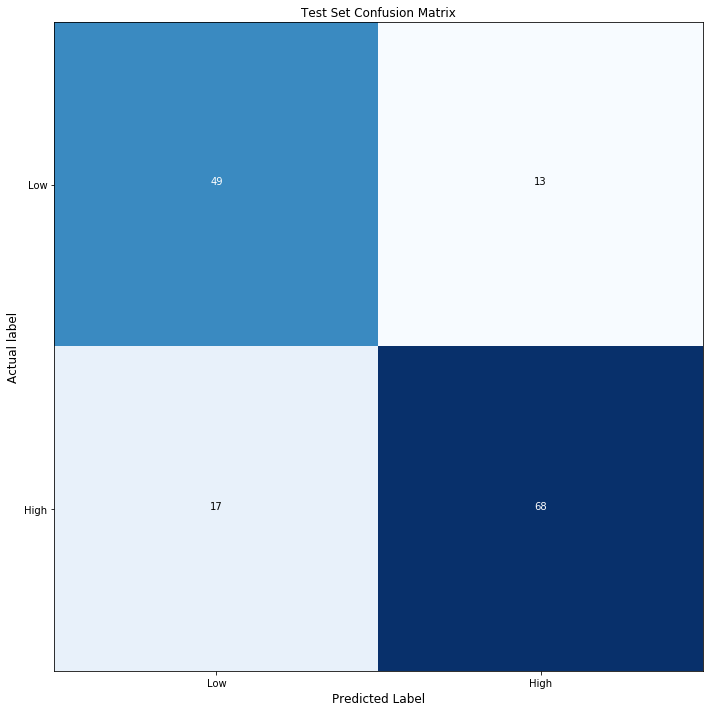

In [12]:
cnfM:.ml.confmat[dict1[`ytest];pred1]
.ml.confdict[dict1[`ytest];pred1;1b]
.ml.displayCM[value cnfM;`Low`High;"Test Set Confusion Matrix";()]

## Conclusions

In conclusion as can be seen from the above results the use of a random forest classifier was useful in allowing for the classification of next day last hour business vs previous day, to be more consistent than simply choosing one case to always be true.

It should also be noted that the quality of results garnered from the running of the classifications depends on the location that the data is split. This is an inherent problem in predicting on human behaviour influenced systems as it is difficult to predict on outlying cases which have a non repeating signature.

---